In [ ]:
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.4/99.4 kB 3.0 MB/s eta 0:00:00


In [ ]:
import networkx as nx
import osmnx as ox

ox.__version__

'2.0.0'

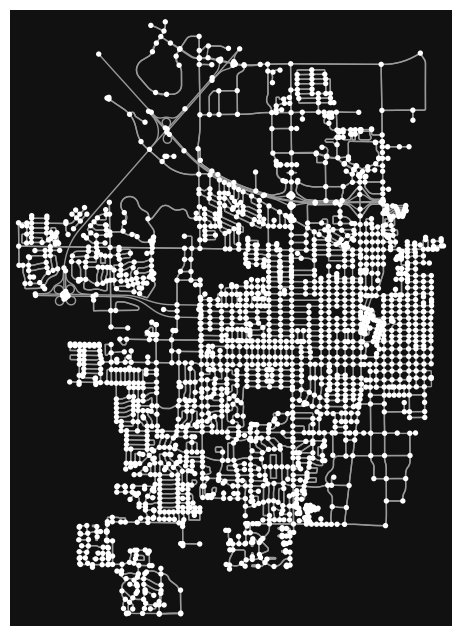

In [ ]:
G = ox.graph_from_place("Champaign, Illinois, USA", network_type="drive")
fig, ax = ox.plot_graph(G)

In [ ]:
# you can convert your graph to node and edge GeoPandas GeoDataFrames
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_nodes.head()

,y,x,street_count,highway,ref,geometry
osmid,,,,,,
37945137,40.116378,-88.270283,4,NaN,NaN,POINT (-88.27028 40.11638)
37945139,40.117389,-88.270301,4,NaN,NaN,POINT (-88.2703 40.11739)
37945140,40.118360,-88.270312,4,NaN,NaN,POINT (-88.27031 40.11836)
37945142,40.120148,-88.270335,4,NaN,NaN,POINT (-88.27034 40.12015)
37945145,40.121343,-88.270336,4,NaN,NaN,POINT (-88.27034 40.12134)


In [ ]:
gdf_nodes.shape

(2257, 6)

In [ ]:
gdf_edges.head()

osmid      highway maxspeed  \
u        v        key                                    
37945137 38032634 0    237756215      primary   30 mph   
         37945139 0      5324506  residential   30 mph   
         38033571 0      5333756  residential   30 mph   
37945139 37945140 0      5324506  residential   30 mph   
         38162699 0      5344871  residential   30 mph   

                                         name  oneway reversed      length  \
u        v        key                                                        
37945137 38032634 0    West University Avenue    True    False  141.591522   
         37945139 0       North Draper Avenue   False    False  112.454436   
         38033571 0       South Draper Avenue   False    False  100.397028   
37945139 37945140 0       North Draper Avenue   False    False  107.974478   
         38162699 0          West Park Avenue   False    False  185.303243   

                                                                geometry  \
u        v        key                                                      
37945137 38032634 0    LINESTRING (-88.27028 40.11638, -88.26862 40.1...   
         37945139 0    LINESTRING (-88.27028 40.11638, -88.27029 40.1...   
         38033571 0    LINESTRING (-88.27028 40.11638, -88.27029 40.1...   
37945139 37945140 0    LINESTRING (-88.2703 40.11739, -88.27031 40.11...   
         38162699 0    LINESTRING (-88.2703 40.11739, -88.27248 40.11...   

                      lanes  ref access bridge junction  
u        v        key                                    
37945137 38032634 0     NaN  NaN    NaN    NaN      NaN  
         37945139 0     NaN  NaN    NaN    NaN      NaN  
         38033571 0     NaN  NaN    NaN    NaN      NaN  
37945139 37945140 0     NaN  NaN    NaN    NaN      NaN  
         38162699 0     NaN  NaN    NaN    NaN      NaN

In [ ]:
# convert graph to line graph so edges become nodes and vice versa
edge_centrality = nx.closeness_centrality(nx.line_graph(G))
nx.set_edge_attributes(G, edge_centrality, "edge_centrality")

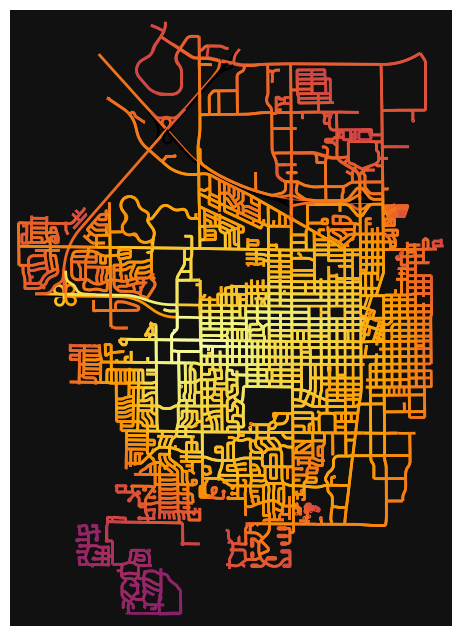

In [ ]:
# color edges in original graph with closeness centralities from line graph
ec = ox.plot.get_edge_colors_by_attr(G, "edge_centrality", cmap="inferno")
fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=2, node_size=0)

In [ ]:
type(edge_centrality)

dict

In [ ]:
# ((37992018, 37991979, 0), 0.045483097360208335)

In [ ]:
hub = max(edge_centrality, key=edge_centrality.get)

In [ ]:
hub

(37992018, 37991979, 0)

In [ ]:
result = gdf_nodes.loc[37992018]

In [ ]:
result

,37992018
y,40.112893
x,-88.282858
street_count,4
highway,traffic_signals
ref,NaN
geometry,POINT (-88.282858 40.112893)


In [ ]:
result = gdf_nodes.loc[37991979]
result

,37991979
y,40.114371
x,-88.282004
street_count,3
highway,NaN
ref,NaN
geometry,POINT (-88.282004 40.114371)


The most central node will be the hub which is (one that


In [ ]:
import random
for u, v, k, data in G.edges(data=True, keys=True):
    # Assume average speed (mph) if not provided
    speed_mph = data.get("maxspeed", 25)  # Default to 25 mph if maxspeed is not available
    if isinstance(speed_mph, list):  # Handle cases where speed is a list
        if isinstance(speed_mph[0], str):
            speed_mph = speed_mph[0].split()[0]
        speed_mph = float(speed_mph[0])
    else:
        # speed_mph = speed_.split()[0]
        if isinstance(speed_mph, str):
            speed_mph = speed_mph.split()[0]
        speed_mph = float(speed_mph)
    speed_mps = speed_mph * 0.44704  # Convert mph to meters per second
    data["travel_time"] = data["length"] / speed_mps  # Travel time in seconds
    # break

In [ ]:
edge_centrality = nx.betweenness_centrality(nx.Graph(G))  # Convert to undirected for centrality
hub_node = max(edge_centrality, key=edge_centrality.get)

# Step 4: Generate random delivery locations
all_nodes = list(G.nodes)
n_deliveries = 20  # Number of delivery locations
delivery_nodes = random.sample(all_nodes, n_deliveries)

In [ ]:
print(hub_node)
print(delivery_nodes)

37992018
[38099611, 38092384, 38088414, 38006032, 37973957, 38003262, 37977456, 37973897, 37945271, 1529108219, 37975584, 38095493, 37974014, 38048877, 38050696, 37980921, 37978366, 1520525462, 38064746, 38001790]


In [ ]:
travel_times = {
            node: nx.shortest_path_length(G, hub_node, node, weight="travel_time")for node in delivery_nodes}
# Find the nearest node
next_node = min(travel_times, key=travel_times.get)

In [ ]:
next_node

38092384

In [ ]:
gdf_nodes.loc[next_node]

,38092384
y,40.119286
x,-88.27504
street_count,3
highway,NaN
ref,NaN
geometry,POINT (-88.27504 40.119286)


. Traffic Impact on Deliveries
Robust Hypothesis:
Hypothesis: Increased traffic congestion reduces the number of deliveries completed within a day.
Use dynamic traffic data to simulate varying levels of congestion.
Model peak hours and off-peak hours to evaluate how traffic timing affects delivery efficiency.
Experimentation Enhancements:
Categorize traffic levels (e.g., low, medium, high) and analyze their specific impact.
Test the hypothesis for different routes (urban, suburban, and rural areas).
Introduce stochastic elements: random delays due to accidents, road closures, etc.